In [326]:
# import packages

import pandas as pd
import numpy as np
import re
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Model Prediction Task I

You are tasked to build a predictive algorithm to determine the factors affecting prices of residential properties in Singapore. You need to provide insights to your reporting officer to detail one or more strategies in curbing housing prices inflation.

Your fellow colleagues should be able to access and contribute to your code to replicate the same insights. Their local devices do not have GPU access. Provide justification for any of the choices you have made.

### Create Combined Dataset 

In [258]:
approval_1990_1999 = pd.read_csv("data/resale-flat-prices-based-on-approval-date-1990-1999.csv")
approval_2000_2012 = pd.read_csv("data/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv")
registration_2012_2014 = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv")
registration_2015_2016 = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv")
registration_2017 = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

In [259]:
print(f"resale-flat-prices-based-on-approval-date-1990-1999 with shape {approval_1990_1999.shape}\n", approval_1990_1999.head())
print(f"\nresale-flat-prices-based-on-approval-date-2000-feb-2012 {approval_2000_2012.shape}\n", approval_2000_2012.head())

resale-flat-prices-based-on-approval-date-1990-1999 with shape (287200, 10)
      month        town flat_type block       street_name storey_range  \
0  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
1  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     04 TO 06   
2  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
3  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     07 TO 09   
4  1990-01  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     04 TO 06   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  
0            31.0        IMPROVED                 1977          9000  
1            31.0        IMPROVED                 1977          6000  
2            31.0        IMPROVED                 1977          8000  
3            31.0        IMPROVED                 1977          6000  
4            73.0  NEW GENERATION                 1976         47200  

resale-flat-prices-based-on-approval-date-2000-feb-2012 (

In [260]:
print(f"resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014 with shape {registration_2012_2014.shape}\n", registration_2012_2014.head())
print(f"\nresale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016 {registration_2015_2016.shape}\n", registration_2015_2016.head())
print(f"\nresale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv {registration_2017.shape}\n", registration_2017.head())

resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014 with shape (52203, 10)
      month        town flat_type block        street_name storey_range  \
0  2012-03  ANG MO KIO    2 ROOM   172   ANG MO KIO AVE 4     06 TO 10   
1  2012-03  ANG MO KIO    2 ROOM   510   ANG MO KIO AVE 8     01 TO 05   
2  2012-03  ANG MO KIO    3 ROOM   610   ANG MO KIO AVE 4     06 TO 10   
3  2012-03  ANG MO KIO    3 ROOM   474  ANG MO KIO AVE 10     01 TO 05   
4  2012-03  ANG MO KIO    3 ROOM   604   ANG MO KIO AVE 5     06 TO 10   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  
0            45.0        Improved                 1986      250000.0  
1            44.0        Improved                 1980      265000.0  
2            68.0  New Generation                 1980      315000.0  
3            67.0  New Generation                 1984      320000.0  
4            67.0  New Generation                 1980      321000.0  

resale-flat-prices-based-on-regi

Upon reading the names of the 5 csv files, there are two distinct naming for datasets: approval and registration. However, given that approval ranges from 1990 to february 2012 and registration ranges from march 2012 and onwards, it seems more like a change in naming convention than completely different datasets given that the variables are mostly identical. The assumption is therefore that these 5 datasets are actually tracking the exact same thing, and thus can be combined into one full dataset.

However, there is some data manipulation required as the variable input data types and value styles differ across the years (i.e. datasets), with some datasets even having new variables. A deeper analysis of the differences between datasets to be combined will be conducted to determine the final dataset data types and standardisation of variables.

#### storey_range

It seems that the storey_range is in 3s. However, in registration_2012_2014, 6838 ranges are incorrect:

| storey_range      | Count |
| :---        |    :----:   |
| 01 TO 05 | 2700 |
| 06 TO 10 | 2474 |
| 11 TO 15 | 1259 |
| 16 TO 20 | 265 |
| 21 TO 25 | 92 |
| 26 TO 30 | 39 |
| 31 TO 35 | 2 |
| 36 TO 40 | 7 |

Since they cannot be changed to the predefined storey_ranges as below, they will be removed as including them will likely confuse the prediction model since it blurs the boundary between classes. 6838 out of 52203 (~13%) will be removed.

| storey_range      |
| :---        | 
|01 TO 03  |  
|04 TO 06  |  
|07 TO 09  |  
|10 TO 12  |  
|13 TO 15  |  
|16 TO 18  |  
|19 TO 21  |   
|22 TO 24  |   
|25 TO 27  |   
|28 TO 30  |   
|31 TO 33  |    
|34 TO 36  |    
|37 TO 39  |    
|40 TO 42  |    
|43 TO 45  |     
|46 TO 48 |      
|49 TO 51|       


In [376]:
approval_1990_1999["storey_range"].value_counts().sort_index()

storey_range
01 TO 03    60966
04 TO 06    75455
07 TO 09    69394
10 TO 12    58444
13 TO 15    13692
16 TO 18     4391
19 TO 21     2609
22 TO 24     1713
25 TO 27      536
Name: count, dtype: int64

In [377]:
approval_2000_2012["storey_range"].value_counts().sort_index()

storey_range
01 TO 03    76806
04 TO 06    95136
07 TO 09    84673
10 TO 12    71215
13 TO 15    24521
16 TO 18     9018
19 TO 21     4209
22 TO 24     2521
25 TO 27     1032
28 TO 30      434
31 TO 33       31
34 TO 36       20
37 TO 39       23
40 TO 42       12
Name: count, dtype: int64

In [378]:
registration_2012_2014["storey_range"].value_counts().sort_index()

storey_range
01 TO 03     9692
01 TO 05     2700
04 TO 06    11456
06 TO 10     2474
07 TO 09     9878
10 TO 12     8370
11 TO 15     1259
13 TO 15     3304
16 TO 18     1319
16 TO 20      265
19 TO 21      605
21 TO 25       92
22 TO 24      351
25 TO 27      183
26 TO 30       39
28 TO 30      115
31 TO 33       23
31 TO 35        2
34 TO 36       32
36 TO 40        7
37 TO 39       26
40 TO 42       11
Name: count, dtype: int64

In [379]:
registration_2015_2016["storey_range"].value_counts().sort_index()

storey_range
01 TO 03    7050
04 TO 06    8961
07 TO 09    8220
10 TO 12    7048
13 TO 15    3176
16 TO 18    1300
19 TO 21     514
22 TO 24     369
25 TO 27     189
28 TO 30     119
31 TO 33      53
34 TO 36      55
37 TO 39      54
40 TO 42      27
43 TO 45       8
46 TO 48       8
49 TO 51       2
Name: count, dtype: int64

In [380]:
registration_2017["storey_range"].value_counts().sort_index()

storey_range
01 TO 03    14471
04 TO 06    18697
07 TO 09    16944
10 TO 12    15173
13 TO 15     7519
16 TO 18     3421
19 TO 21     1485
22 TO 24     1099
25 TO 27      604
28 TO 30      381
31 TO 33      158
34 TO 36      160
37 TO 39      152
40 TO 42       82
43 TO 45        8
46 TO 48       13
49 TO 51        7
Name: count, dtype: int64

#### data types

In [255]:
"""
Input: <list<DataFrame>> list of dataframes
Description: returns each variable's datatype
Output: <DataFrame> dataframe comparing variables and datatypes
"""


def get_datatypes(dfs, df_names) :
    
    df_datatypes = pd.DataFrame()
    for i in range(len(dfs)) :
        df = dfs[i]
        df_name = df_names[i]
        col_datatypes = {}
        for col in df.columns :
            col_datatypes[col] = [type(df[col][0])]
        col_df = pd.DataFrame.from_dict(col_datatypes, orient='index').reset_index()
        col_df.columns = ["variable", f"data type_{df_name}"]
        if i == 0 :
            df_datatypes = col_df
        else :
            df_datatypes = df_datatypes.merge(col_df, on='variable', how='outer')


    return df_datatypes


In [262]:
dfs = [approval_1990_1999, approval_2000_2012, registration_2012_2014, registration_2015_2016, registration_2017]
get_datatypes(dfs, ["1990_1999", "2000_2012", "2012_2014", "2015_2016", "2017"])

,variable,data type_1990_1999,data type_2000_2012,data type_2012_2014,data type_2015_2016,data type_2017
0,block,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
1,flat_model,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
2,flat_type,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
3,floor_area_sqm,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>
4,lease_commence_date,<class 'numpy.int64'>,<class 'numpy.int64'>,<class 'numpy.int64'>,<class 'numpy.int64'>,<class 'numpy.int64'>
5,month,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
6,remaining_lease,NaN,NaN,NaN,<class 'numpy.int64'>,<class 'str'>
7,resale_price,<class 'numpy.int64'>,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>
8,storey_range,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
9,street_name,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>


all 5 datasets have the same datatypes for block, flat_model, flat_type, floor_area_sqm, lease_commence_date, month, storey range, street_name and town. For resale_price, 1990_1999 is only one using int64 while from 2000, float is used. Assuming this datatype input change happened starting from 2000, resale_price in 1990_1999 will be changed to float as well for consistency. For remaining_lease, it seems like it was only created after 2015, explaining why this variable did not exist from 1990 to 2014. However, 2017 onwards uses string to include months while 2015_2016 uses int64, only taking the number of years. To capture the true value of remaining_lease, we will maintain the datatype int64 and convert values into months instead. For flat_model, 1990_1999 capitalises all variable inputs while the other datasets did not. To standardise, flat_model will all be capitalised for ease later when encoding categorical variables.

In [276]:
"""
Input: <str> remaining_lease value (e.g. 61 years 04 months)
Description: parses a string and converts years and months into only months
Output: <int> number of months
"""
def convert_to_total_months(lease_str):
    if not isinstance(lease_str, str):
        return 0
    
    # Extract digit for years and digit for months
    years_match = re.search(r'(\d+)\s*years?', lease_str)
    months_match = re.search(r'(\d+)\s*months?', lease_str)
    
    years = int(years_match.group(1)) if years_match else 0
    months = int(months_match.group(1)) if months_match else 0
    
    return (years * 12) + months

In [395]:
"""
Input: <DataFrame> dataframes to be combined
Description:
    - change approval_1990_1999 resale_price datatype to float
    - remove registration_2012_2014 incorrect storey_ranges
    - capitalise flat_model
    - convert remaining_lease to months
Output: <DataFrame> combined dataframe
"""

def create_df(approval_1990_1999, approval_2000_2012, registration_2012_2014, registration_2015_2016, registration_2017) :
    
    # change approval_1990_1999 resale_price datatype
    approval_1990_1999["resale_price"] = approval_1990_1999["resale_price"].astype(float)

    # remove registration_2012_2014 incorrect storey_ranges
    remove_storey_ranges = ["01 TO 05", "06 TO 10", "11 TO 15", "16 TO 20", "21 TO 25", "26 TO 30", "31 TO 35", "36 TO 40"]
    registration_2012_2014 = registration_2012_2014.loc[~registration_2012_2014["storey_range"].isin(remove_storey_ranges)].reset_index(drop=True)
    
    # convert remaining_lease to months
    registration_2015_2016["remaining_lease"] = registration_2015_2016["remaining_lease"]*12
    registration_2017['remaining_lease'] = registration_2017['remaining_lease'].apply(convert_to_total_months)

    # create df
    df = pd.concat([approval_1990_1999, approval_2000_2012, registration_2012_2014, registration_2015_2016, registration_2017])
    
    # capitalise flat_model
    df["flat_model"] = df["flat_model"].str.upper()

    df = df.reset_index(drop=True)
    
    return df

In [396]:
df = create_df(approval_1990_1999, approval_2000_2012, registration_2012_2014, registration_2015_2016, registration_2017)
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
819738,2020-09,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,IMPROVED,1987,440000.0,0.0
819739,2020-09,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,IMPROVED,1987,458000.0,0.0
819740,2020-09,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,IMPROVED,1987,490000.0,0.0
819741,2020-09,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,MAISONETTE,1987,558000.0,0.0


### Exploratory Data Analysis

#### Duplicates
The 1843 duplicates will not be dropped because there is no unique identifier, it could so happen that multiple units in a storey_range were sold in the exact same block and street_name.

In [445]:
df.shape[0]-df.drop_duplicates().shape[0]

1843

#### Missing Values

The dataset is mostly intact, with the only null values coming from remaining_lease as it was only recorded from 2015 and confirmed by checking no null values from 2015.

In [397]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819743 entries, 0 to 819742
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                819743 non-null  object 
 1   town                 819743 non-null  object 
 2   flat_type            819743 non-null  object 
 3   block                819743 non-null  object 
 4   street_name          819743 non-null  object 
 5   storey_range         819743 non-null  object 
 6   floor_area_sqm       819743 non-null  float64
 7   flat_model           819743 non-null  object 
 8   lease_commence_date  819743 non-null  int64  
 9   resale_price         819743 non-null  float64
 10  remaining_lease      117527 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 68.8+ MB


In [398]:
registration_2015_2016.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37153 entries, 0 to 37152
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                37153 non-null  object 
 1   town                 37153 non-null  object 
 2   flat_type            37153 non-null  object 
 3   block                37153 non-null  object 
 4   street_name          37153 non-null  object 
 5   storey_range         37153 non-null  object 
 6   floor_area_sqm       37153 non-null  float64
 7   flat_model           37153 non-null  object 
 8   lease_commence_date  37153 non-null  int64  
 9   remaining_lease      37153 non-null  int64  
 10  resale_price         37153 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 3.1+ MB


In [399]:
registration_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80374 entries, 0 to 80373
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                80374 non-null  object 
 1   town                 80374 non-null  object 
 2   flat_type            80374 non-null  object 
 3   block                80374 non-null  object 
 4   street_name          80374 non-null  object 
 5   storey_range         80374 non-null  object 
 6   floor_area_sqm       80374 non-null  float64
 7   flat_model           80374 non-null  object 
 8   lease_commence_date  80374 non-null  int64  
 9   remaining_lease      80374 non-null  int64  
 10  resale_price         80374 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 6.7+ MB


#### Outliers

Box plots will be used to identify outliers as interquartile range is robust to outliers and does not assume a specific distribution unlike Z-score. Even though there are many properties with floor_area_sqm and resale_price above the third quartile, it is likely due to the big range of property sizes and thus prices. 

Text(0.5, 1.0, 'Box Plot for floor_area_sqm')

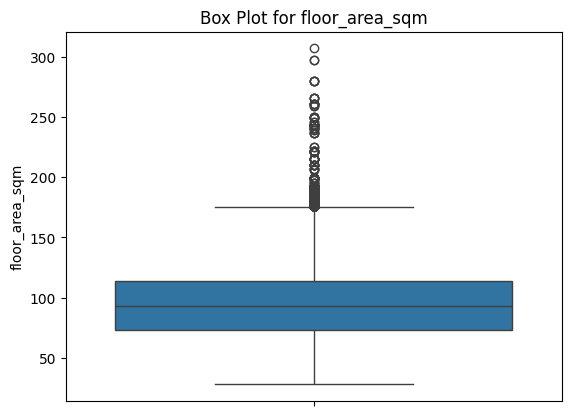

In [400]:
ax = sns.boxplot(y=df["floor_area_sqm"].dropna())
ax.set_title("Box Plot for floor_area_sqm")

Text(0.5, 1.0, 'Box Plot for resale_price')

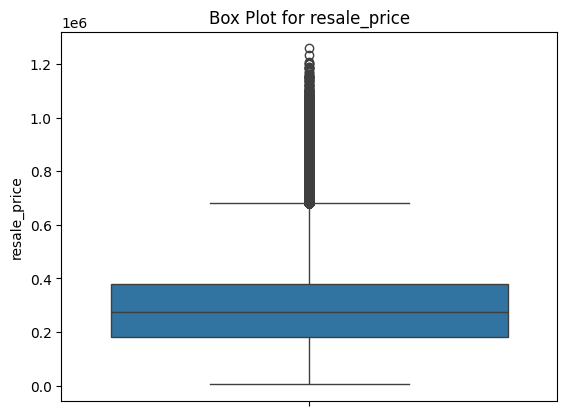

In [401]:
ax = sns.boxplot(y=df["resale_price"].dropna())
ax.set_title("Box Plot for resale_price")

Text(0.5, 1.0, 'Box Plot for remaining_lease')

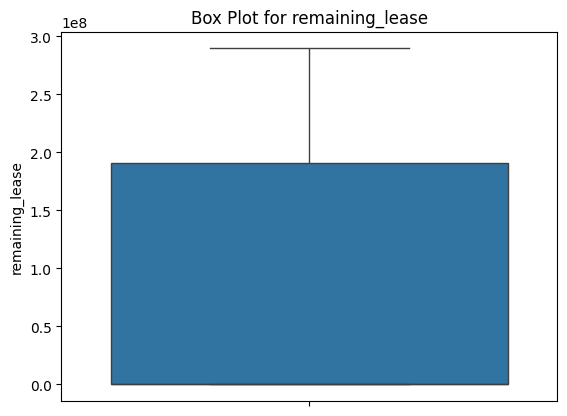

In [402]:
ax = sns.boxplot(y=df["remaining_lease"].dropna())
ax.set_title("Box Plot for remaining_lease")

#### month

By using seasonal decompose, we can see that there is seasonality - periodic fluctuations that repeat at regular intervals.

Text(0.5, 1.0, 'Number of houses sold per month from 1990 to 2020')

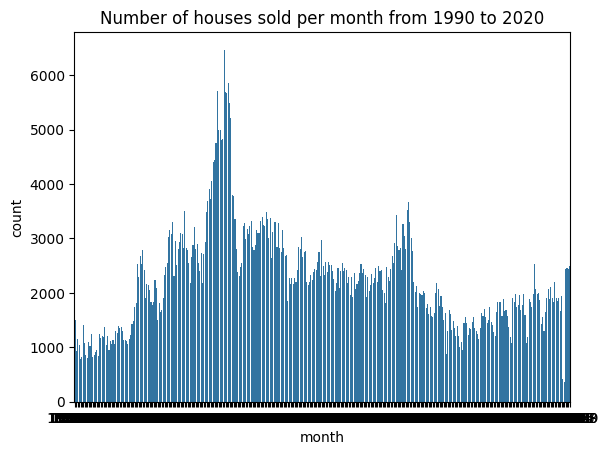

In [440]:
data = df.groupby('month').size().reset_index(name='count')
ax = sns.barplot(x="month", y="count", data=data)
ax.set_title("Number of houses sold per month from 1990 to 2020")

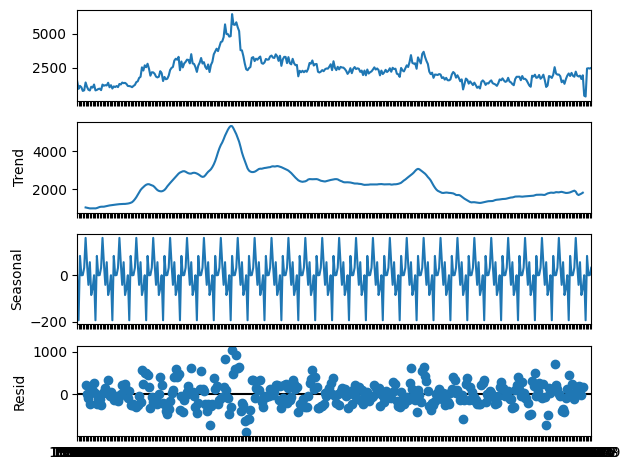

In [404]:
ts = data.set_index('month')
result = seasonal_decompose(ts, model='additive', period=12)
result.plot()
plt.show()

#### town

Some towns are more popular than others and have different maximum resale_prices by town.

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1712/1891525427.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


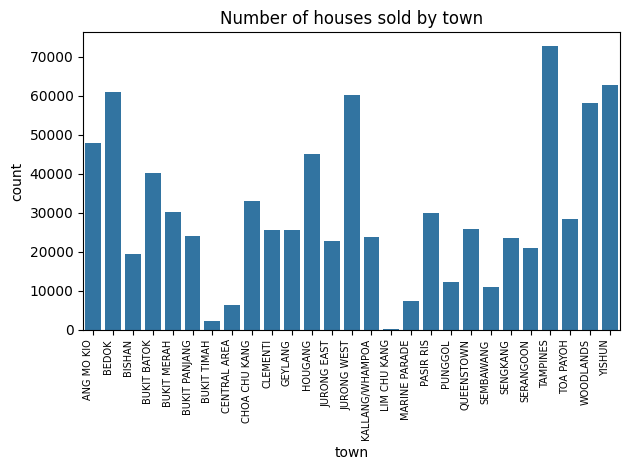

In [439]:
data = df.groupby('town').size().reset_index(name='count').sort_values("town")
ax = sns.barplot(y="count", x="town", data=data, legend=True)
ax.set_title("Number of houses sold by town")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1712/2395755033.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


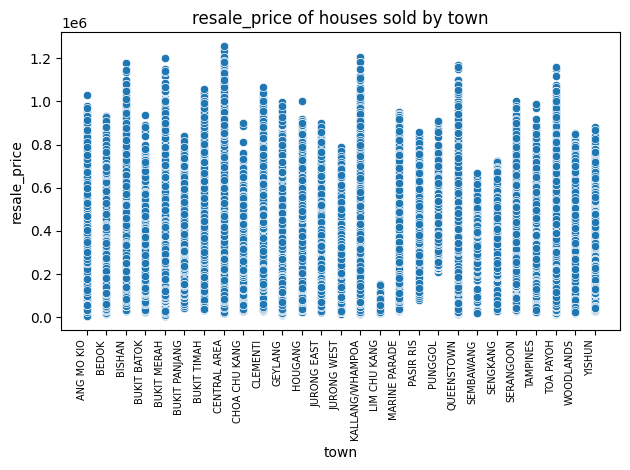

In [438]:
ax = sns.scatterplot(y="resale_price", x="town", data=df.sort_values("town"), legend=True)
ax.set_title("resale_price of houses sold by town")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

#### storey_range

Lower floors are sold more, but they also have the lower starting resale_prices compared to higher floors.

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1712/3300989319.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


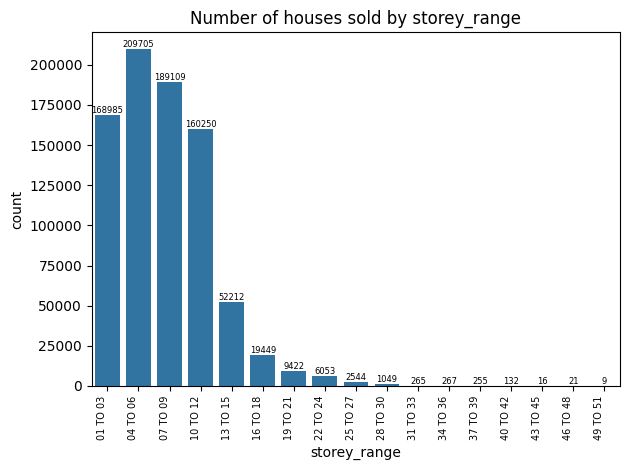

In [436]:
data = df.groupby('storey_range').size().reset_index(name='count')
ax = sns.barplot(y="count", x="storey_range", data=data, legend=True)
for container in ax.containers:
    ax.bar_label(container, fontsize=6)
ax.set_title("Number of houses sold by storey_range")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1712/525765342.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


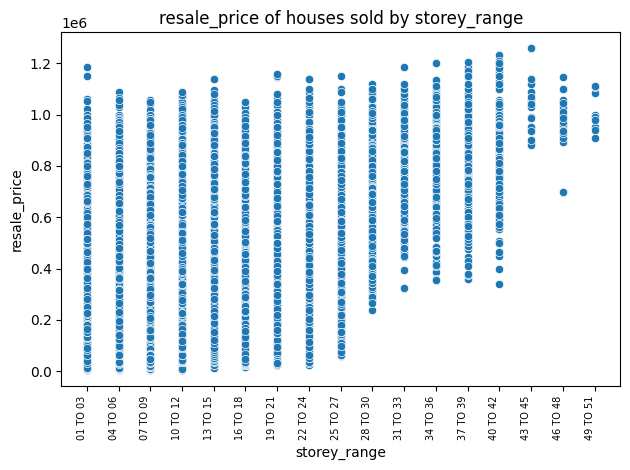

In [433]:
ax = sns.scatterplot(y="resale_price", x="storey_range", data=df.sort_values("storey_range"), legend=True)
ax.set_title("resale_price of houses sold by storey_range")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

#### floor_area_sqm

For lower floor_area_sqm, resale_price is almost guaranteed to be lower. However, for higher floor_area_sqm, the resale_price ranges from low to high. 

Text(0.5, 1.0, 'resale_price of houses sold by floor_area_sqm')

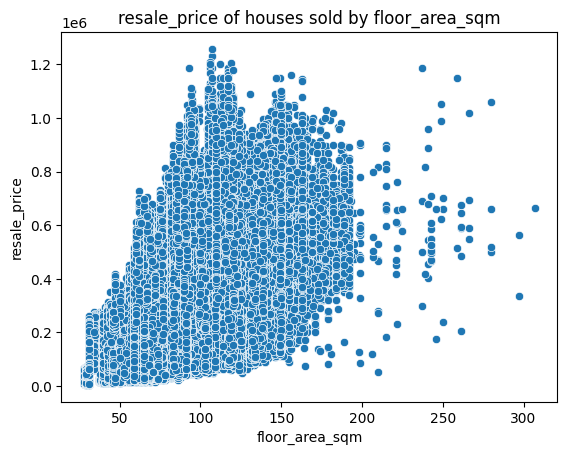

In [431]:
ax = sns.scatterplot(y="resale_price", x="floor_area_sqm", data=df.sort_values("storey_range"), legend=True)
ax.set_title("resale_price of houses sold by floor_area_sqm")

#### flat_model

popularity of flat_model has little impact on the resale_price, but flat_model can impact the minimum and maximum resale_price.

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1712/2113408113.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


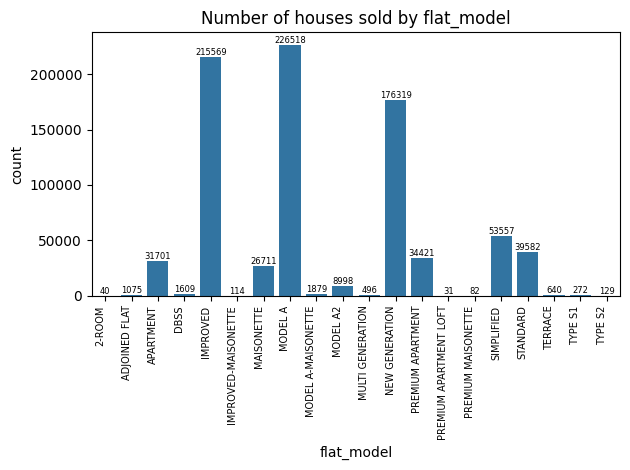

In [460]:
data = df.groupby('flat_model').size().reset_index(name='count').sort_values("flat_model")
ax = sns.barplot(y="count", x="flat_model", data=data, legend=True)
for container in ax.containers:
    ax.bar_label(container, fontsize=6)
ax.set_title("Number of houses sold by flat_model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

#### lease_commence_date

houses with lease_commence_date in the 1980s have the highest number of houses sold, with newer houses being sold less. the minimum resale_price increases with lease_commence_date, indicating higher resale_prices for newer houses. 

/var/folders/hl/c6gvw07j74b8ncx9w_tf7x100000gp/T/ipykernel_1712/3105411640.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)


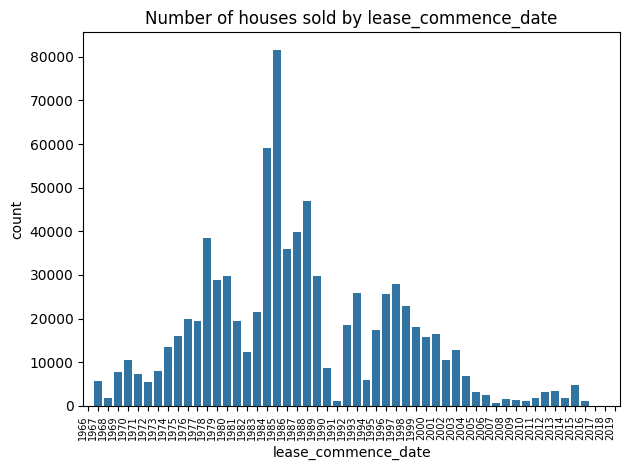

In [428]:
data = df.groupby('lease_commence_date').size().reset_index(name='count').sort_values("lease_commence_date")
ax = sns.barplot(y="count", x="lease_commence_date", data=data, legend=True)
ax.set_title("Number of houses sold by lease_commence_date")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.tight_layout()

Text(0.5, 1.0, 'resale_price of houses sold by lease_commence_date')

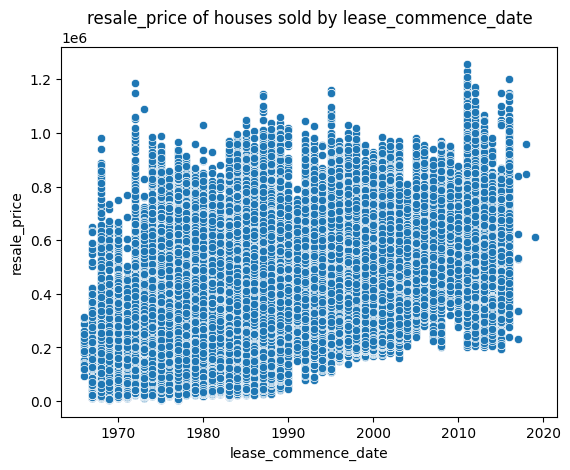

In [430]:
ax = sns.scatterplot(y="resale_price", x="lease_commence_date", data=df.sort_values("lease_commence_date"), legend=True)
ax.set_title("resale_price of houses sold by lease_commence_date")

#### remaining_lease

resale_price decreases as remaining_lease decreases.

Text(0.5, 1.0, 'resale_price of houses sold by remaining_lease')

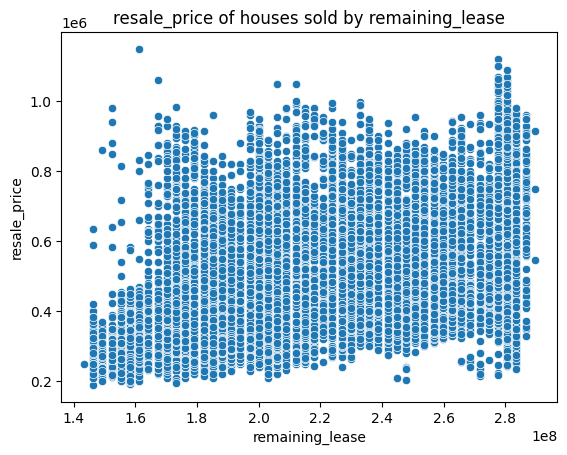

In [458]:
data = df.replace(0, np.nan).dropna(subset=['remaining_lease'])
data = data[data['remaining_lease'] != 0]
ax = sns.scatterplot(y="resale_price", x="remaining_lease", data=data.sort_values("remaining_lease"), legend=True)
ax.set_title("resale_price of houses sold by remaining_lease")

In [306]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'remaining_lease'],
      dtype='object')

# Model Prediction Task II

Since we are building a predictive algorithm, we will transform the categorical variables (town, storey_range, flat_model) using one hot encoding since most algorithms produce better results with numerical variables.

# Link Analysis Task I

# Link Analysis Task II

# Bonus Question: Link Analysis Task III 